In [0]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

# from utils.preprocessing import extract_log_mel_feats
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))


In [0]:
train_folder = 'drive/My Drive/Audio analytics/data/train/'
#test_folder = './data/audio_test/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

In [0]:
wav_data, sr = load(os.path.join(test_folder, '0a9f4e787d8d2af55683.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [0]:
path_to_csv = os.path.join('drive/My Drive/Audio analytics/data', 'train.csv')
pickle_train_path = os.path.join('drive/My Drive/Audio analytics/data', 'train.pickle')
#pickle_test_path = os.path.join('drive/My Drive/Audio analytics/data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

#extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

0it [00:00, ?it/s]

Total files: 5683


5683it [1:05:54,  1.44it/s]


In [0]:
import numpy as np
import pandas as pd
#import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        #self.fc1 = nn.Linear(33856, 1000)
        self.fc1 = nn.Linear(80960, 8000)
        self.fc2 = nn.Linear(8000, 1000)
        self.fc3 = nn.Linear(1000, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [0]:
random_input = torch.randn(1, 1, 64, 64, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

In [0]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)
loss = criterion(output, target)
print(loss.item())
loss.backward()
optimizer.step() 

In [0]:
import pickle
import os

pickle_train_path = os.path.join('drive/My Drive/Audio analytics/data', 'train.pickle')
pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [0]:
def prepare_shape(feature):
    tmp = feature
    #N = 64 # размер во времени (можно увеличить, должно стать лучше)
    N = 128
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [0]:
from sklearn.model_selection import train_test_split

X = np.asarray([prepare_shape(row['feature']) for row in pickle_train_data])
y = np.asarray([row['label_id'] for row in pickle_train_data])

x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [0]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [0]:
from torch.utils.data import Dataset

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        # Случайный сдвиг
        shift = np.random.randint(x.shape[1])
        self.x = np.roll(x, shift, axis=1)
        #self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [0]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

In [0]:
sample_x, sample_y = val_dset[2]
print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [0]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [0]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

In [0]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
#optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer = optim.Adam(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x.float())
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            optimizer.zero_grad()

            output = network(x.float())
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list)) 
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

## Пятый результат
Изменения: 
*   Разделение данных с помощью train_test_split(0.2)   
*   Изменение размера во времени на 128
*   Добавление случайного сдвига
*   Добавление полносвязного слоя (fc2)
*   Изменение optimizer на Adam(lr=0.001)

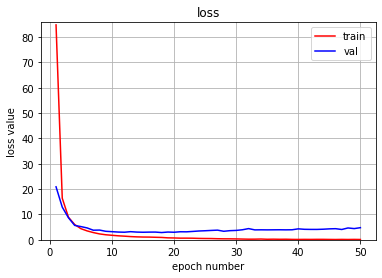

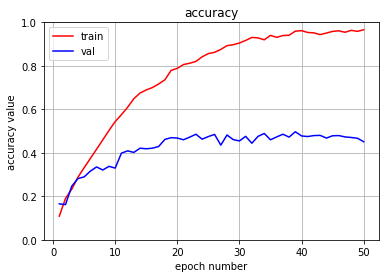

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

## Четвертый результат
Изменения: 
*   Разделение данных с помощью train_test_split(0.2)   
*   Добавление случайного сдвига
*   Добавление полносвязного слоя (fc2)
*   Изменение optimizer на Adam(lr=0.0001)

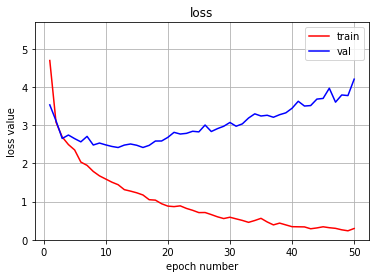

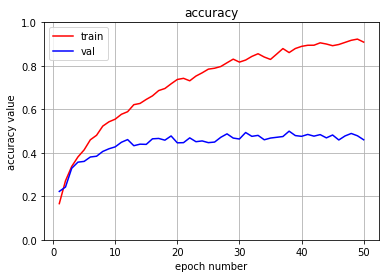

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

## Третий результат
Изменения: 
*   Разделение данных с помощью train_test_split(0.2)   
*   Добавление случайного сдвига
*   Добавление полносвязного слоя (fc2)
*   Изменение optimizer на Adam(lr=0.001)

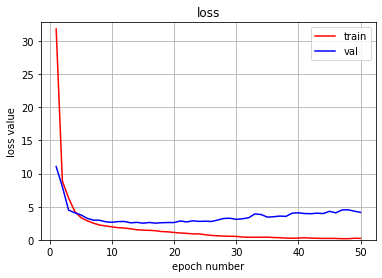

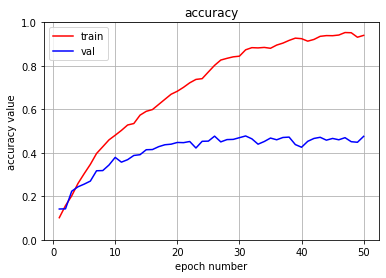

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

## Второй результат
Изменения: 
*   Разделение данных с помощью train_test_split(0.2)   
*   Изменение размера во времени на 128
*   Добавление случайного сдвига
*   Добавление двух полносвязных слоев (fc2, fc3)
*   Изменение optimizer на Adam(lr=0.0001)

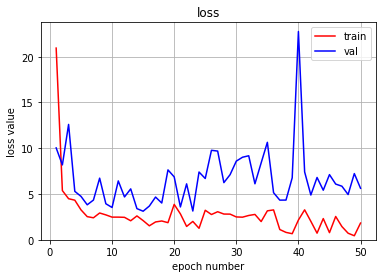

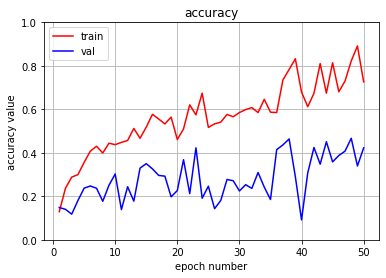

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

## Первый результат
Изменения: 
*   Разделение данных с помощью train_test_split(0.2)   
*   Изменение размера во времени на 128
*   Добавление второго полносвязного (fc2) слоя
*   Изменение optimizer на Adam(lr=0.001)


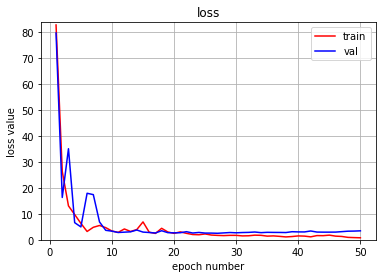

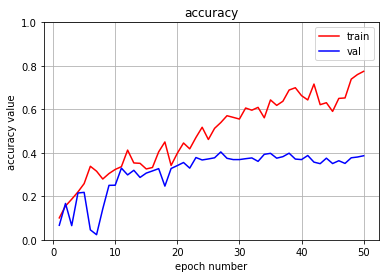

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

## Исходный результат

*   Разделение данных без применения функции train_test_split(0.2)   
*   Размер во времени равен 64
*   Без случайного сдвига
*   Один полносвязный слой
*   optimizer.SGD()

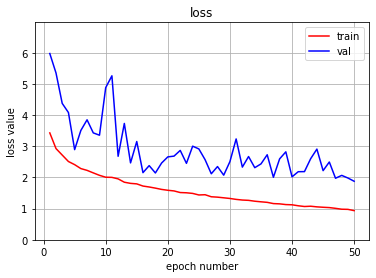

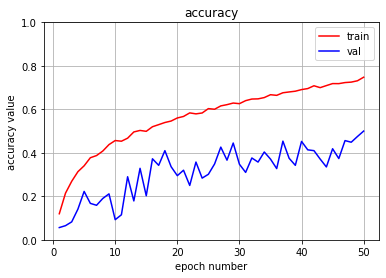

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()